In [1]:
import os
import sys
import matplotlib.pyplot as plt


proj_root = os.path.abspath(os.getcwd())
if proj_root not in sys.path:
    sys.path.insert(0, proj_root)

Lädt die Modelle (`model`, `Admin`, `Address`), alle Data-Access-Klassen für Hotel-, Raum-, Buchungs-, Rechnungs- und Nutzerdaten sowie die Business-Logic-Manager (Hotel, Admin, Room, Booking, Invoice).
Stellt so sicher, dass Datenbankzugriff und Geschäftslogik im Skript komplett verfügbar sind.

In [2]:
#Notwendige Model Imports
import model
from model import Admin
from model import Address
#Notwendige DataAccess Imports
from data_access.hotel_data_access import HotelDataAccess
from data_access.room_data_access import RoomDataAccess
from data_access.booking_data_access import BookingDataAccess
from data_access.facility_data_access import FacilityDataAccess
from data_access.invoice_data_access import InvoiceDataAccess
from data_access.admin_data_access import AdminDataAccess
from data_access.address_data_access import AddressDataAccess
from data_access.guest_data_access import GuestDataAccess
from data_access.room_type_data_access import RoomTypeDataAccess
#Notwendige BusinessLogic Imports
from business_logic.hotel_manager import HotelManager
from business_logic.admin_manager import AdminManager
from business_logic.room_manager import RoomManager
from business_logic.booking_analyse_manager import BookingAnalyticsManager
from business_logic.booking_manager import BookingManager
from business_logic.invoice_manager import InvoiceManager
# Notwendiges Datumformat Import
from datetime import date, datetime

Erzeugt den vollständigen Pfad zur SQLite-Datenbank „hotel_reservation_sample.db“ im Projekt-Unterordner.
Dieser `db_path` wird an alle DataAccess-Klassen übergeben, um eine konsistente DB-Verbindung aufzubauen.

In [3]:
# Pfad zur SQLite-Datenbank
db_path = os.path.join(proj_root, "database", "hotel_reservation_sample.db")

Erstellt alle DataAccess-Objekte (Hotel, Room, Booking, Facility, Address, Invoice, Admin, Guest, RoomType) mit demselben `db_path` für konsistente SQLite-Verbindungen.
So steht im weiteren Verlauf des Notebooks jederzeit ein zentraler Datenbankzugriff zur Verfügung.

In [4]:
# DataAccess-Objekte erzeugen
hotel_dao = HotelDataAccess(db_path)
room_dao = RoomDataAccess(db_path)
booking_dao = BookingDataAccess(db_path)
facility_dao = FacilityDataAccess(db_path)
address_da = AddressDataAccess(db_path)
invoice_dao = InvoiceDataAccess(db_path)
admin_dao = AdminDataAccess(db_path)
guest_da = GuestDataAccess(db_path)
room_type_dao = RoomTypeDataAccess(db_path)

Erzeugt Manager Instanzen, in die die zuvor konfigurierten DAO-Objekte injiziert werden, damit zum Beispiel beim HotelManager alle Hotel- und Raum-bezogenen Geschäftsprozesse dieselbe Datenbankverbindung nutzen.


In [5]:
manager = HotelManager(hotel_data_access=hotel_dao, room_data_access=room_dao)

room_manager = RoomManager(room_data_access=room_dao, facility_data_access=facility_dao)

booking_manager = BookingManager(booking_da=booking_dao, room_manager=room_manager)

invoice_manager = InvoiceManager(invoice_data_access=invoice_dao,                                                             booking_data_access=booking_dao)

admin_manager = AdminManager(admin_data_access=admin_dao,
                             hotel_da=hotel_dao,address_da=address_da, room_da=room_dao, room_type_da=room_type_dao, booking_da=booking_dao,guest_da=guest_da, invoice_da=invoice_dao)

analytics = BookingAnalyticsManager(booking_dao, room_dao)

Neuen Admin erstellen

In [6]:
admin = Admin(
    admin_id=1,
    username="Yannick44",
    password="Password9?",
    email="cesco8@gmail.com",
    vorname="Cesco",
    nachname="Meggiolaro"
)

admin_dao.create_admin(admin)
print("Admin erfolgreich erstellt.")

Admin erfolgreich erstellt.


Alle Admins anzeigen

In [8]:
admins = admin_dao.get_all_admins()

for admin in admins:
    print(f"ID: {admin.admin_id}, Username: {admin.username}, Password {admin.password} Email: {admin.email}, Vorname: {admin.vorname}, Nachname: {admin.nachname}")

ID: 1, Username: Yannick44, Password Password9? Email: cesco8@gmail.com, Vorname: Cesco, Nachname: Meggiolaro
ID: 2, Username: Yannick44, Password Password9? Email: cesco8@gmail.com, Vorname: Cesco, Nachname: Meggiolaro


Admin Login für Admin User Stories

In [9]:
#Beispieladmin in DB vorhanden: PW: Cesco8 & Password8?
admin_username = "Yannick44"           #
admin_password = "Password9?"

if admin_manager.authenticate(admin_username, admin_password):
    print(f"Willkommen {admin_manager.get_logged_in_admin().vorname}")
else:
    print("Login fehlgeschlagen – kein Zugriff.")

Willkommen Cesco


1. Als Gast möchte ich die verfügbaren Hotels durchsuchen, damit
ich dasjenige auswählen kann, welches meinen Wünschen
entspricht. Wünsche sind:


1.1. Ich möchte alle Hotels in einer Stadt durchsuchen,
damit ich das Hotel nach meinem bevorzugten Standort
(Stadt) auswählen kann.


In [9]:
# nach Stadt filtern im String
hotels_in_WunschStadt = manager.show_hotels_by_city("Basel")

if not hotels_in_WunschStadt:
    print("Keine Hotels in dieser Stadt gefunden.")
else:
    for h in hotels_in_WunschStadt:
        print(f"{h.name} – {h.address.street}, {h.address.zip_code}, {h.address.city}")

Les Trois Rois – Freiestrasse 10, 4051, Basel


1.2. Ich möchte alle Hotels in einer Stadt nach der
Anzahl der Sterne (z.B. mindestens 4 Sterne) durchsuchen.

In [12]:
# Stadt und min_stars angeben
city = "Basel"
min_stars = 5

# 3) Methode aufrufen
result = manager.show_hotels_by_city_and_min_stars(city, min_stars)

# 4) Ausgabe, falls Treffer vorhanden
if result:
    print(f"Gefundene Hotels in '{city}' mit mindestens {min_stars} Sternen:")
    for h in result:
        print(f"  • {h.name} ({h.stars} Sterne) – {h.address.street}, {h.address.zip_code}")

Gefundene Hotels in 'Basel' mit mindestens 5 Sternen:
  • Les Trois Rois (5 Sterne) – Freiestrasse 10, 4051


1.3. Ich möchte alle Hotels in einer Stadt durchsuchen,
die Zimmer haben, die meiner Gästezahl entsprechen (nur 1
Zimmer pro Buchung)

In [13]:
# 1) Stadt und Gästeanzahl angeben
city = "zürich"
guest_count = 1

# 2) Methode aufrufen
result = manager.find_hotels_by_city_and_guests(city, guest_count)

# 3 Ausgabe, falls Treffer vorhanden
if result:
    print(f"Gefundene Hotels in '{city}' mit Zimmern für mindestens {guest_count} Gäste:")
    for h in result:
        print(f"  • {h.name} – {h.address.street}, {h.address.zip_code}")
else:
    print(f"Keine Hotels in '{city}' mit Zimmern für mindestens {guest_count} Gäste gefunden.")

Gefundene Hotels in 'zürich' mit Zimmern für mindestens 1 Gäste:
  • Hotel Baur au Lac – Bahnhofstrasse 1, 8001


1.4. Ich möchte alle Hotels in einer Stadt durchsuchen,
die während meines Aufenthaltes ("von" (check_in_date)
und "bis" (check_out_date)) Zimmer zur Verfügung haben,
damit ich nur relevante Ergebnisse sehe.

In [14]:
# Abfrageparameter definieren
city = "Genève"                 ## Beispiel Buchung in DB in Genève ist von 2025, 8, 20 bis  2025, 8, 22
check_in = date(2025, 8, 1)
check_out = date(2025, 8, 17)

# Verfügbare Hotels abrufen
verfuegbare_hotels = manager.find_available_hotels_by_city_and_dates(city, check_in, check_out, booking_dao)

# Ausgabe der Ergebnisse
if verfuegbare_hotels:
    print(f"Verfügbare Hotels in '{city}' vom {check_in} bis {check_out}:")
    for h in verfuegbare_hotels:
        print(f"{h.name} – {h.address.street}, {h.address.zip_code}")
else:
    print(f"Keine verfügbaren Hotels in '{city}' vom {check_in} bis {check_out}.")

Verfügbare Hotels in 'Genève' vom 2025-08-01 bis 2025-08-17:
Four Seasons Hôtel des Bergues – Rue du Rhône 42, 1204


1.5. Ich möchte Wünsche kombinieren können, z.B. die
verfügbaren Zimmer zusammen mit meiner Gästezahl und der
mindest Anzahl Sterne.


In [8]:
# Parameter definieren --> Hotel in Genf hat 5 Sterne, Room für max 4 Leute uund booking von 2025-8-20 - 2025-8-22
stadt = "Genève"
check_in = datetime(2025, 8, 23)
check_out = datetime(2025, 8, 24)
min_sterne = 4
gaesteanzahl = 2

# Methode aufrufen
verfuegbare_hotels = manager.find_hotels_by_criteria(
    city=stadt,
    check_in_date=check_in,
    check_out_date=check_out,
    min_stars=min_sterne,
    guest_count=gaesteanzahl,
    booking_da=booking_dao
)

# Ausgabe
if verfuegbare_hotels:
    print(f"Verfügbare Hotels in '{stadt}' vom {check_in.date()} bis {check_out.date()} (mind. {min_sterne} Sterne, für {gaesteanzahl} Gäste):")
    for hotel in verfuegbare_hotels:
        print(f"  • {hotel.name} – {hotel.address.street}, {hotel.address.zip_code} {hotel.address.city}")
else:
    print(f"Keine passenden Hotels in '{stadt}' für die angegebenen Kriterien gefunden.")

Verfügbare Hotels in 'Genève' vom 2025-08-23 bis 2025-08-24 (mind. 4 Sterne, für 2 Gäste):
  • Four Seasons Hôtel des Bergues – Rue du Rhône 42, 1204 Genève


1.6. Ich möchte die folgenden Informationen pro Hotel
sehen: Name, Adresse, Anzahl der Sterne.

In [9]:
infos = manager.show_all_hotel_infos()

print("Verfügbare Hotels:")
for eintrag in infos:
    print(" •", eintrag)


Verfügbare Hotels:
 • Hotel Baur au Lac – Bahnhofstrasse 1, 8001 Zürich (5 Sterne)
 • Four Seasons Hôtel des Bergues – Rue du Rhône 42, 1204 Genève (5 Sterne)
 • Grand Hotel National – Pilatusstrasse 15, 6003 Luzern (5 Sterne)
 • Bellevue Palace – Marktgasse 59, 3011 Bern (5 Sterne)
 • Les Trois Rois – Freiestrasse 10, 4051 Basel (5 Sterne)
 • Hotel Bernblick – Lindenweg 8, 3012 Däniken (3 Sterne)


2. Als Gast möchte ich Details zu verschiedenen Zimmertypen
(Single, Double, Suite usw.), die in einem Hotel verfügbar
sind, sehen, einschliesslich der maximalen Anzahl von Gästen
für dieses Zimmer, Beschreibung, Preis und Ausstattung, um eine
fundierte Entscheidung zu treffen.

2.1. Ich möchte die folgenden Informationen pro Zimmer
sehen: Zimmertyp, max. Anzahl der Gäste, Beschreibung,
Ausstattung, Preis pro Nacht und Gesamtpreis.


In [10]:
# Optional: Check-in und Check-out setzen (für Gesamtpreisberechnung)
check_in = date(2025, 7, 11)
check_out = date(2025, 7, 15)

# Zimmerdetails abrufen
room_infos = room_manager.show_room_details()

# Ausgabe
for room in room_infos:
    ausstattung = ", ".join([f.facility_name for f in room.facilities])

    print(f"Zimmer {room.room_number} – {room.room_type.description}")
    print(f"  Max. Gäste     : {room.room_type.max_guests}")
    print(f"  Ausstattung    : {ausstattung if ausstattung else 'Keine'}")

    # Preis pro Nacht
    print(f"  Preis pro Nacht: {room.price_per_night:.2f} CHF")

    # Optional: Gesamtpreis berechnen, wenn Check-in/Check-out gesetzt
    if check_in and check_out and check_out > check_in:
        nächte = (check_out - check_in).days
        gesamtpreis = room.price_per_night * nächte
        print(f"  Gesamtpreis    : {gesamtpreis:.2f} CHF für {nächte} Nächte")

    print("-" * 60)

Zimmer 101 – Single
  Max. Gäste     : 1
  Ausstattung    : WiFi, TV
  Preis pro Nacht: 250.00 CHF
  Gesamtpreis    : 1000.00 CHF für 4 Nächte
------------------------------------------------------------
Zimmer 102 – Double
  Max. Gäste     : 2
  Ausstattung    : WiFi
  Preis pro Nacht: 400.00 CHF
  Gesamtpreis    : 1600.00 CHF für 4 Nächte
------------------------------------------------------------
Zimmer 201 – Suite
  Max. Gäste     : 4
  Ausstattung    : Air Conditioning
  Preis pro Nacht: 650.00 CHF
  Gesamtpreis    : 2600.00 CHF für 4 Nächte
------------------------------------------------------------
Zimmer 301 – Family Room
  Max. Gäste     : 5
  Ausstattung    : Mini Bar
  Preis pro Nacht: 900.00 CHF
  Gesamtpreis    : 3600.00 CHF für 4 Nächte
------------------------------------------------------------
Zimmer 401 – Penthouse
  Max. Gäste     : 6
  Ausstattung    : Keine
  Preis pro Nacht: 1500.00 CHF
  Gesamtpreis    : 6000.00 CHF für 4 Nächte
--------------------------------

2.2. Ich möchte nur die verfügbaren Zimmer sehen, sofern
ich meinen Aufenthalt (von – bis) spezifiziert habe.


In [11]:
check_in = date(2025, 8, 20)
check_out = date(2025, 8, 22)

verfuegbare_zimmer = room_manager.find_available_rooms_by_dates(
    check_in_date=check_in,
    check_out_date=check_out,
    booking_dao=booking_dao
)

for room in verfuegbare_zimmer:
    ausstattung = ", ".join([f.facility_name for f in room.facilities])
    print(f"Zimmer {room.room_number} – {room.room_type.description}")
    print(f"  Hotel: {room.hotel.name}, Adresse: {room.hotel.address.street} {room.hotel.address.city}")
    print(f"  Max. Gäste     : {room.room_type.max_guests}")
    print(f"  Ausstattung    : {ausstattung if ausstattung else 'Keine'}")
    print(f"  Preis pro Nacht: {room.price_per_night:.2f} CHF")

    # Optional: Gesamtpreis berechnen
    if check_in and check_out and check_out > check_in:
        nächte = (check_out - check_in).days
        gesamtpreis = room.price_per_night * nächte
        print(f"  Gesamtpreis    : {gesamtpreis:.2f} CHF für {nächte} Nächte")

    print("-" * 60)

Zimmer 101 – Single
  Hotel: Hotel Baur au Lac, Adresse: Bahnhofstrasse 1 Zürich
  Max. Gäste     : 1
  Ausstattung    : WiFi, TV
  Preis pro Nacht: 250.00 CHF
  Gesamtpreis    : 500.00 CHF für 2 Nächte
------------------------------------------------------------
Zimmer 102 – Double
  Hotel: Hotel Baur au Lac, Adresse: Bahnhofstrasse 1 Zürich
  Max. Gäste     : 2
  Ausstattung    : WiFi
  Preis pro Nacht: 400.00 CHF
  Gesamtpreis    : 800.00 CHF für 2 Nächte
------------------------------------------------------------
Zimmer 301 – Family Room
  Hotel: Grand Hotel National, Adresse: Pilatusstrasse 15 Luzern
  Max. Gäste     : 5
  Ausstattung    : Mini Bar
  Preis pro Nacht: 900.00 CHF
  Gesamtpreis    : 1800.00 CHF für 2 Nächte
------------------------------------------------------------
Zimmer 401 – Penthouse
  Hotel: Bellevue Palace, Adresse: Marktgasse 59 Bern
  Max. Gäste     : 6
  Ausstattung    : Keine
  Preis pro Nacht: 1500.00 CHF
  Gesamtpreis    : 3000.00 CHF für 2 Nächte
----

3. Als Admin des Buchungssystems möchte ich die Möglichkeit haben,
Hotelinformationen zu pflegen, um aktuelle Informationen im
System zu haben.

3.1. Ich möchte neue Hotels zum System hinzufügen


In [8]:
if admin_manager.get_logged_in_admin():
    adresse = Address(
        address_id=0,  # Wird automatisch von der DB vergeben
        street="Lindenweg 8",
        city="Däniken",
        zip_code=3012
    )
    try:
        neues_hotel = manager.create_new_hotel(
            name="Hotel Bernblick",
            stars=3,
            address=adresse,
            address_da=address_da
        )
        print("Hotel wurde erfolgreich erstellt:")
        print(f"Hotel-ID: {neues_hotel.hotel_id}")
        print(f"Address-ID: {neues_hotel.address.address_id}")
        print(f"{neues_hotel.name}, {neues_hotel.address.street}, {neues_hotel.address.zip_code} {neues_hotel.address.city}")
    except Exception as e:
        print("Fehler beim Erstellen des Hotels:", e)
else:
    print("Zugriff verweigert – bitte zuerst als Admin einloggen.")

Hotel wurde erfolgreich erstellt:
Hotel-ID: 14
Address-ID: 6
Hotel Bernblick, Lindenweg 8, 3012 Däniken


3.2. Ich möchte Hotels aus dem System entfernen

In [7]:
# Admin-Prüfung
if admin_manager.get_logged_in_admin():
    # Hotel-ID zum Löschen
    hotel_id_to_delete = 19

    # Vorher: Liste aller Hotels anzeigen
    print("Hotels vor dem Löschen:")
    for h in manager.show_all_hotels_basic():
        print(f"Hotel-ID: {h.hotel_id} | Name: {h.name}")

    # Hotel löschen
    erfolgreich = manager.delete_hotel(hotel_id_to_delete)

    # Rückmeldung
    if erfolgreich:
        print(f"\nHotel mit ID {hotel_id_to_delete} wurde gelöscht.")
    else:
        print(f"\nKein Hotel mit ID {hotel_id_to_delete} gefunden – nichts gelöscht.")

    # Danach: Liste nochmals anzeigen
    print("\nHotels nach dem Löschen:")
    for h in manager.show_all_hotels_basic():
        print(f"Hotel-ID: {h.hotel_id} | Name: {h.name}")

else:
    print("Zugriff verweigert – bitte zuerst als Admin einloggen.")

Hotels vor dem Löschen:
Hotel-ID: 1 | Name: Hotel Baur au Lac
Hotel-ID: 2 | Name: Four Seasons Hôtel des Bergues
Hotel-ID: 3 | Name: Grand Hotel National
Hotel-ID: 4 | Name: Eisenarm
Hotel-ID: 5 | Name: Les Trois Rois
Hotel-ID: 14 | Name: Hotel Bernblick
Hotel-ID: 15 | Name: Hotel Bernblick

Kein Hotel mit ID 19 gefunden – nichts gelöscht.

Hotels nach dem Löschen:
Hotel-ID: 1 | Name: Hotel Baur au Lac
Hotel-ID: 2 | Name: Four Seasons Hôtel des Bergues
Hotel-ID: 3 | Name: Grand Hotel National
Hotel-ID: 4 | Name: Eisenarm
Hotel-ID: 5 | Name: Les Trois Rois
Hotel-ID: 14 | Name: Hotel Bernblick
Hotel-ID: 15 | Name: Hotel Bernblick


3.3. Ich möchte die Informationen bestimmter Hotels
aktualisieren, z. B. den Namen, die Sterne usw.


In [14]:
# Admin-Prüfung
if admin_manager.get_logged_in_admin():
    # Hotel-ID auswählen zum Anpassen
    hotel_id = 4

    # Vorherige Daten anzeigen
    original_hotel = next((h for h in hotel_dao.read_all_hotel() if h.hotel_id == hotel_id), None)

    if not original_hotel:
        print(f"Hotel mit ID {hotel_id} wurde nicht gefunden.")
    else:
        print("Vorher:")
        print(f"Name: {original_hotel.name}, Sterne: {original_hotel.stars}")
        print(f"Adresse: {original_hotel.address.street}, {original_hotel.address.zip_code} {original_hotel.address.city}")

        # Neue Werte definieren
        neuer_name = "Eisenarm"
        neue_sterne = 5
        neue_adresse = model.Address(
            address_id=original_hotel.address.address_id,
            street="Gassstrassse 7",
            city="Dulliken",
            zip_code=4657
        )
        # Update durchführen
        ok = manager.update_hotel_and_address(
            hotel_id=hotel_id,
            name=neuer_name,
            stars=neue_sterne,
            address=neue_adresse,
            address_da=address_da
        )
        # Ergebnis anzeigen
        if ok:
            updated = next((h for h in hotel_dao.read_all_hotel() if h.hotel_id == hotel_id), None)
            print("\nNachher:")
            print(f"Name: {updated.name}, Sterne: {updated.stars}")
            print(f"Adresse: {updated.address.street}, {updated.address.zip_code} {updated.address.city}")
        else:
            print("Update fehlgeschlagen.")
else:
    print("Zugriff verweigert – bitte zuerst als Admin einloggen.")

Vorher:
Name: Bellevue Palace, Sterne: 5
Adresse: Marktgasse 59, 3011 Bern

Nachher:
Name: Eisenarm, Sterne: 5
Adresse: Gassstrassse 7, 4657 Dulliken


4. Als Gast möchte ich ein Zimmer in einem bestimmten Hotel
buchen, um meinen Urlaub zu planen.


In [10]:
from model import Guest, Room, RoomType, Hotel, Address

# Dummy-Daten (IDs müssen existieren!)
adresse = Address(address_id=1, street="Teststrasse 11", city="Olten", zip_code=4600)
hotel = Hotel(hotel_id=1, name="Hotel Test", stars=3, address=adresse)
room_type = RoomType(room_type_id=1, description="Standard", max_guests=2)
zimmer = Room(room_id=5, room_number="101", price_per_night=120.0, room_type=room_type, hotel=hotel)
gast = Guest(guest_id=1, firstname="Max", lastname="Muster", email="max@muster.ch")

check_in = date(2025, 12, 20)
check_out = date(2025, 12, 22)

# 1. Buchungen vor dem Einfügen anzeigen
print("Buchungen vor dem Einfügen:")
for b in booking_manager.show_bookings():
    print(f"Booking-ID: {b.booking_id}, Room-ID: {b.room_id}, Hotel-ID: {b.hotel_id}, Check-in: {b.check_in_date}, Check-out: {b.check_out_date}")

# 2. Verfügbarkeit prüfen und ggf. buchen
verfuegbare_zimmer = room_manager.find_available_rooms_by_dates(check_in, check_out, booking_dao)
neue_buchung = None

if any(r.room_id == zimmer.room_id for r in verfuegbare_zimmer):
    neue_buchung = booking_dao.create_booking(
        guest_id=gast,
        room_id=zimmer,
        check_in_date=check_in,
        check_out_date=check_out,
        is_cancelled=False,
        total_amount=zimmer.price_per_night * (check_out - check_in).days
    )
    print("\nNeue Buchung erfolgreich erstellt:")
    print(f"Booking-ID: {neue_buchung.booking_id}, Room-ID: {neue_buchung.room_id}, Zeitraum: {check_in} bis {check_out}")
else:
    print("\nZimmer ist im gewünschten Zeitraum nicht verfügbar.")

# 3. Buchungen nach dem Einfügen anzeigen
print("\nBuchungen nach dem Einfügen:")
for b in booking_manager.show_bookings():
    print(f"Booking-ID: {b.booking_id}, Room-ID: {b.room_id}, Hotel-ID: {b.hotel_id}, Check-in: {b.check_in_date}, Check-out: {b.check_out_date}")

Buchungen vor dem Einfügen:
Booking-ID: 1, Room-ID: 1, Hotel-ID: 1, Check-in: 2025-06-01, Check-out: 2025-06-05
Booking-ID: 2, Room-ID: 2, Hotel-ID: 1, Check-in: 2025-07-10, Check-out: 2025-07-15
Booking-ID: 3, Room-ID: 3, Hotel-ID: 2, Check-in: 2025-08-20, Check-out: 2025-08-22
Booking-ID: 4, Room-ID: 4, Hotel-ID: 3, Check-in: 2025-09-05, Check-out: 2025-09-10
Booking-ID: 5, Room-ID: 5, Hotel-ID: 4, Check-in: 2025-10-01, Check-out: 2025-10-07
Booking-ID: 6, Room-ID: 1, Hotel-ID: 1, Check-in: 2025-12-17, Check-out: 2025-12-19
Booking-ID: 7, Room-ID: 5, Hotel-ID: 4, Check-in: 2025-12-17, Check-out: 2025-12-19

Neue Buchung erfolgreich erstellt:
Booking-ID: 8, Room-ID: 5, Zeitraum: 2025-12-20 bis 2025-12-22

Buchungen nach dem Einfügen:
Booking-ID: 1, Room-ID: 1, Hotel-ID: 1, Check-in: 2025-06-01, Check-out: 2025-06-05
Booking-ID: 2, Room-ID: 2, Hotel-ID: 1, Check-in: 2025-07-10, Check-out: 2025-07-15
Booking-ID: 3, Room-ID: 3, Hotel-ID: 2, Check-in: 2025-08-20, Check-out: 2025-08-22
Boo

5. Als Gast möchte ich nach meinem Aufenthalt eine Rechnung
erhalten, damit ich einen Zahlungsnachweis habe.
Hint: Fügt einen Eintrag in der «Invoice» Tabelle hinzu.


In [6]:
try:
    booking_id = int(input("Booking-ID eingeben: "))
    invoice = invoice_manager.create_invoice_for_existing_booking(booking_id)

    print("Rechnung erfolgreich erstellt:")
    print(f"Rechnungs-ID: {invoice.invoice_id}")
    print(f"Zu Buchung:   {invoice.booking}")
    print(f"Betrag:       {invoice.total_amount} CHF")
    print(f"Rechnungsdatum: {invoice.issue_date}")
except Exception as e:
    print(f"Fehler beim Erstellen der Rechnung: {e}")

KeyboardInterrupt: Interrupted by user

6.Als Gast möchte ich meine Buchung stornieren, damit ich nicht
belastet werde, wenn ich das Zimmer nicht mehr benötige.
Hint: Sorgt für die entsprechende Invoice

In [ ]:
# Booking-ID auswählen zum anpassen
booking_id = 5

# Vorherige Daten anzeigen
original_booking = next((b for b in booking_manager.show_bookings() if b.booking_id == booking_id), None)

if not original_booking:
    print(f"Booking mit ID {booking_id} wurde nicht gefunden.")
else:
    print("Vorher:")
    print(f"Guest: {original_booking.guest},")
    print(      f" Check-In: {original_booking.check_in_date}, Check-Out: {original_booking.check_out_date}")
    print(f"Storniert?: {original_booking.is_cancelled}, Gesamtbetrag {original_booking.total_amount}")
    #Ausschliessen, dass die Buchung vorher storniert war
if not original_booking.is_cancelled:
    # Neue Werte definieren
    cancelled = True
    # Update durchführen
    ok = booking_manager.update_booking(
        booking_id=booking_id,
        check_in_date=original_booking.check_in_date,
        check_out_date=original_booking.check_out_date,
        is_cancelled=cancelled,
        total_amount=original_booking.total_amount,
        guest_id=original_booking.guest
    )
    # Ergebnis anzeigen
    if ok:
        gelöscht = invoice_dao.delete_invoice_by_booking_id(booking_id)
        if gelöscht:
            print(f"Die zugehörige Rechnung zur Buchung {booking_id} wurde gelöscht")
        else:
            print(f"Es wurde keine Rechnung zur Buchung {booking_id} gefunden.")

        updated = next((b for b in booking_manager.show_bookings() if b.booking_id == booking_id), None)
        print("\nNachher:"),
        print(f"Guest-ID: {updated.guest}, Check-In: {updated.check_in_date}, Check-Out: {updated.check_out_date}")
        print(f"Storniert: {updated.is_cancelled}, {updated.total_amount} CHF")
    else:
        print("Update fehlgeschlagen.")
else: print("Buchung ist bereits storniert.")

7. Als Gast möchte ich eine dynamische Preisgestaltung auf der
Grundlage der Nachfrage sehen, damit ich ein Zimmer zum besten
Preis buchen kann.
Hint: Wendet in der Hochsaison höhere und in der Nebensaison
niedrigere Tarife an


In [ ]:
# beispielzimmer holen
rooms = room_manager.show_room_details()
room = rooms[2]  # Erstes Zimmer

# Zeitraum definieren
check_in = date(2025, 7, 10)
check_out = date(2025, 7, 15)

# Preisberechnung
base_price = room.price_per_night
num_nights = (check_out - check_in).days
total_base_price = base_price * num_nights
dynamic_price = room_manager.calculate_dynamic_price(room, check_in, check_out)

# Ausgabe
print(f"Zimmernummer: {room.room_number}")
print(f"Zeitraum: {check_in} bis {check_out} ({num_nights} Nächte)")
print(f"Basispreis pro Nacht: {base_price:.2f} CHF")
print(f"Gesamtpreis ohne Dynamik: {total_base_price:.2f} CHF")
print(f"Dynamischer Gesamtpreis: {dynamic_price:.2f} CHF")

8. Als Admin des Buchungssystems möchte ich alle Buchungen aller
Hotels sehen können, um eine Übersicht zu erhalten.


In [6]:
if admin_manager.get_logged_in_admin():
    all_bookings = booking_manager.show_all_bookings_with_all_hotels()

    print(f"Es wurden {len(all_bookings)} Buchungen gefunden:\n")

    for b in all_bookings:
        print(f"Buchung-ID: {b.booking_id} | "
              f"Hotel-ID: {b.hotel.hotel_id if hasattr(b, 'hotel') else 'N/A'} | "
              f"Hotel-Name: {b.hotel.name if hasattr(b, 'hotel') else 'N/A'} | "
              f"Zimmer-Nr: {b.room.room_number if hasattr(b, 'room') else 'N/A'} | "
              f"Check-In: {b.check_in_date} | "
              f"Check-Out: {b.check_out_date} | "
              f"Storniert: {b.is_cancelled} | "
              f"Gesamtbetrag: {b.total_amount} | "
              f"Gast-ID: {b.guest}")
else:
    print("Zugriff verweigert – bitte zuerst als Admin einloggen.")

Es wurden 5 Buchungen gefunden:

Buchung-ID: 1 | Hotel-ID: 1 | Hotel-Name: Hotel Baur au Lac | Zimmer-Nr: 101 | Check-In: 2025-06-01 | Check-Out: 2025-06-05 | Storniert: 0 | Gesamtbetrag: 1000.0 | Gast-ID: 1
Buchung-ID: 2 | Hotel-ID: 1 | Hotel-Name: Hotel Baur au Lac | Zimmer-Nr: 102 | Check-In: 2025-07-10 | Check-Out: 2025-07-15 | Storniert: 0 | Gesamtbetrag: 2000.0 | Gast-ID: 2
Buchung-ID: 3 | Hotel-ID: 2 | Hotel-Name: Four Seasons Hôtel des Bergues | Zimmer-Nr: 201 | Check-In: 2025-08-20 | Check-Out: 2025-08-22 | Storniert: 0 | Gesamtbetrag: 1300.0 | Gast-ID: 3
Buchung-ID: 4 | Hotel-ID: 3 | Hotel-Name: Grand Hotel National | Zimmer-Nr: 301 | Check-In: 2025-09-05 | Check-Out: 2025-09-10 | Storniert: 1 | Gesamtbetrag: 0.0 | Gast-ID: 4
Buchung-ID: 5 | Hotel-ID: 4 | Hotel-Name: Bellevue Palace | Zimmer-Nr: 401 | Check-In: 2025-10-01 | Check-Out: 2025-10-07 | Storniert: 0 | Gesamtbetrag: 9000.0 | Gast-ID: 5


9. Als Admin möchte ich eine Liste der Zimmer mit ihrer
Ausstattung sehen, damit ich sie besser bewerben kann.



In [ ]:
if admin_manager.get_logged_in_admin():
    rooms = room_manager.get_rooms_with_facilities()

    for room in rooms:
        print(f"Zimmer {room.room_number}:")
        if room.facilities:
            for facility in room.facilities:
                print(f"  - {facility.facility_name}")
        else:
            print("  (Keine Ausstattung vorhanden)")
else:
    print("Zugriff verweigert – bitte zuerst als Admin einloggen.")

10. Als Admin möchte ich in der Lage sein, Stammdaten zu verwalten,
z.B. Zimmertypen, Einrichtungen, und Preise in Echtzeit zu
aktualisieren, damit das Backend-System aktuelle Informationen
hat.

10.1 Guest

In [6]:
#Guest Update
guest_id = int(input("Guest-ID (wird nicht verändert): "))

print("\nGäste vor dem Update:")
for g in guest_da.read_all_guests():
    print(f"Guest-ID: {g.guest_id} | Name: {g.firstname} {g.lastname} | Email: {g.email} | Telefonnummer: {g.phone_number}")

try:
    firstname = input("Neuer Vorname: ")
    lastname = input("Neuer Nachname: ")
    email = input("Neue Email-Adresse: ")
    phone_number = input("Neuer Telefonnummer: ")

    updated_guest = admin_manager.update_guest_admin(
        guest_id=guest_id,
        firstname=firstname,
        lastname=lastname,
        email=email,
        phone_number=phone_number
    )
    print("\nGäste nach dem Update:")
    for g in guest_da.read_all_guests():
        print(f"Guest-ID: {g.guest_id} | Name: {g.firstname} {g.lastname} | Email: {g.email}| Telefonnummer: {g.phone_number}")

except Exception as e:
    print(f"\n️ Fehler beim Gast-Update: {e}")


Gäste vor dem Update:
Guest-ID: 1 | Name: Max Muster | Email: max@example.com | Telefonnummer: None
Guest-ID: 2 | Name: Sophie Meier | Email: sophie.meier@example.ch | Telefonnummer: None
Guest-ID: 3 | Name: Luca Rossi | Email: luca.rossi@example.ch | Telefonnummer: None
Guest-ID: 4 | Name: Elena Keller | Email: elena.keller@example.ch | Telefonnummer: None
Guest-ID: 5 | Name: Marc Weber | Email: marc.weber@example.ch | Telefonnummer: None

Gäste nach dem Update:
Guest-ID: 1 | Name: Max Muster | Email: max@example.com
Guest-ID: 2 | Name: Sophie Meier | Email: sophie.meier@example.ch
Guest-ID: 3 | Name: Luca Rossi | Email: luca.rossi@example.ch
Guest-ID: 4 | Name: Elena Keller | Email: elena.keller@example.ch
Guest-ID: 5 | Name: Cesco Meggiolaro | Email: cesco.meggio@gmail.com


10.2

In [1]:
#Address
address_id = int(input("Address-ID (wird nicht verändert): "))
street = input("Neue Straße: ")
zip_code = int(input("Neue PLZ: "))
city = input("Neue Stadt: ")


print("\nAdressen vor dem Update:")
a = address_da.show_address_by_id(address_id)
print(f"Address-ID: {a.address_id} | {a.street}, {a.zip_code} {a.city}")

try:
    success = admin_manager.update_address_admin(
        address_id=address_id,
        street=street,
        zip_code=zip_code,
        city=city
    )

    print("\nAdressen nach dem Update:")
    a = address_da.show_address_by_id(address_id)
    print(f"Address-ID: {a.address_id} | {a.street}, {a.zip_code} {a.city}")

except Exception as e:
    print(f"\n Fehler beim Adress-Update: {e}")

KeyboardInterrupt: Interrupted by user

10.3

In [11]:
#Invoice
invoice_id = int(input("Rechnungs-ID (wird nicht verändert): "))

print("\nRechnungen vor dem Update:")
for inv in invoice_dao.read_all_invoices():
    print(f"Invoice-ID: {inv.invoice_id} | Betrag: {inv.total_amount} | Datum: {inv.issue_date}")

try:
    issue_date = input("Neues Ausstellungsdatum (YYYY-MM-DD): ")
    total_amount = int(input("Neuer Gesamtbetrag: "))

    updated_invoice = admin_manager.update_invoice_admin(
        invoice_id=invoice_id,
        issue_date=issue_date,
        total_amount=total_amount
    )
    print("\nRechnungen nach dem Update:")
    for inv in invoice_dao.read_all_invoices():
        print(f"Invoice-ID: {inv.invoice_id} | Betrag: {inv.total_amount} | Datum: {inv.issue_date}")

except Exception as e:
    print(f"\n Fehler beim Rechnungs-Update: {e}")


Rechnungen vor dem Update:


ValueError: Issue Date darf nicht in der Vergangenheit liegen

10.4 Update Room

In [3]:
room_id = int(input("Room-ID (wird nicht verändert): "))

print("\nZimmer vor dem Update:")
for r in room_dao.show_room_details_by():
    print(f"Room-ID: {r.room_id} | Nummer: {r.room_number} | Preis: {r.price_per_night}")

try:
    room_number = int(input("Neue Zimmernummer: "))
    price_per_night = int(input("Neuer Preis pro Nacht: "))



    success = admin_manager.update_room_admin(
        room_id=room_id,
        room_number=room_number,
        price_per_night=price_per_night
    )

    print("\n Zimmer wurde aktualisiert." if success else "\n Update fehlgeschlagen.")

except Exception as e:
    print(f"\n️ Fehler beim Zimmer-Update: {e}")


Zimmer vor dem Update:
Room-ID: 1 | Nummer: 101 | Preis: 250.0
Room-ID: 2 | Nummer: 102 | Preis: 400.0
Room-ID: 3 | Nummer: 201 | Preis: 650.0
Room-ID: 4 | Nummer: 301 | Preis: 900.0
Room-ID: 5 | Nummer: 401 | Preis: 1500.0

⚠️ Fehler beim Zimmer-Update: 'NoneType' object has no attribute 'update_room'


10.5 Update RoomType

In [6]:
room_type_id = int(input("RoomType-ID (wird nicht verändert): "))

print("\nZimmertypen vor dem Update:")
for rt in room_type_dao.read_all_room_types():
    print(f"RoomType-ID: {rt.room_type_id} | Beschreibung: {rt.description} | Max Gäste: {rt.max_guests}")

try:
    description = input("Neue Beschreibung: ")
    max_guests = int(input("Neue maximale Gästeanzahl: "))

    updated_rt = admin_manager.update_room_type_admin(
        room_type_id=room_type_id,
        description=description,
        max_guests=max_guests
    )

    print("\nZimmertypen nach dem Update:")
    for rt in room_type_dao.read_all_room_types():
        print(f"RoomType-ID: {rt.room_type_id} | Beschreibung: {rt.description} | Max Gäste: {rt.max_guests}")


except Exception as e:
    print(f"\n️ Fehler beim Zimmertyp-Update: {e}")


Zimmertypen vor dem Update:
RoomType-ID: 1 | Beschreibung: Single | Max Gäste: 1
RoomType-ID: 2 | Beschreibung: Double | Max Gäste: 2
RoomType-ID: 3 | Beschreibung: Suite | Max Gäste: 4
RoomType-ID: 4 | Beschreibung: Family Room | Max Gäste: 5
RoomType-ID: 5 | Beschreibung: Penthouse | Max Gäste: 6

⚠️ Fehler beim Zimmertyp-Update: 'NoneType' object has no attribute 'update_room_type'


10.6 Update Booking

In [5]:
# 1. Benutzer wählt Buchung aus
booking_id_to_update = int(input("Buchungs-ID (wird nicht verändert): "))

# 2. Buchungen vor dem Update anzeigen
print("\nBuchungen vor dem Update:")
for b in booking_manager.show_bookings():
    print(f"Booking-ID: {b.booking_id} | Room-ID: {b.room_id} | Hotel-ID: {b.hotel_id} | Zeitraum: {b.check_in_date} bis {b.check_out_date} | Storniert: {b.is_cancelled} | Betrag: {b.total_amount}")

try:
    # 3. Eingabe der neuen Daten (nur Änderbares!)
    check_in = input("Neues Check-in-Datum (YYYY-MM-DD): ")
    check_out = input("Neues Check-out-Datum (YYYY-MM-DD): ")
    is_cancelled = input("Storniert? (ja/nein): ").strip().lower() == "ja"
    total_amount = int(input("Neuer Gesamtbetrag: "))

    # 4. Ursprüngliche Buchung laden → Fremdschlüssel (Gast) nicht veränderbar
    original_booking = next((b for b in booking_manager.show_bookings() if b.booking_id == booking_id_to_update), None)
    if not original_booking:
        raise ValueError("Buchung mit dieser ID wurde nicht gefunden.")

    # 5. Update durchführen
    success = admin_manager.update_booking_admin(
        booking_id=booking_id_to_update,
        check_in_date=check_in,
        check_out_date=check_out,
        is_cancelled=is_cancelled,
        total_amount=total_amount,
        guest_id=original_booking.guest  # Fremdschlüssel NICHT veränderbar
    )

    if success:
        print(f"\n Buchung {booking_id_to_update} wurde erfolgreich aktualisiert.")
    else:
        print(f"\n Aktualisierung fehlgeschlagen.")

except Exception as e:
    print(f"\n Fehler bei der Aktualisierung: {e}")

# 6. Buchungen nach dem Update anzeigen
print("\nBuchungen nach dem Update:")
for b in booking_manager.show_bookings():
    print(f"Booking-ID: {b.booking_id} | Room-ID: {b.room_id} | Hotel-ID: {b.hotel_id} | Zeitraum: {b.check_in_date} bis {b.check_out_date} | Storniert: {b.is_cancelled} | Betrag: {b.total_amount}")


Buchungen vor dem Update:
Booking-ID: 1 | Room-ID: 1 | Hotel-ID: 1 | Zeitraum: 2025-06-01 bis 2025-06-05 | Storniert: 0 | Betrag: 1000.0
Booking-ID: 2 | Room-ID: 2 | Hotel-ID: 1 | Zeitraum: 2025-07-10 bis 2025-07-15 | Storniert: 0 | Betrag: 2000.0
Booking-ID: 3 | Room-ID: 3 | Hotel-ID: 2 | Zeitraum: 2025-08-20 bis 2025-08-22 | Storniert: 0 | Betrag: 1300.0
Booking-ID: 4 | Room-ID: 4 | Hotel-ID: 3 | Zeitraum: 2025-09-05 bis 2025-09-10 | Storniert: 1 | Betrag: 0.0
Booking-ID: 5 | Room-ID: 5 | Hotel-ID: 4 | Zeitraum: 2025-10-01 bis 2025-10-07 | Storniert: 0 | Betrag: 9000.0
Booking-ID: 6 | Room-ID: 1 | Hotel-ID: 1 | Zeitraum: 2025-12-17 bis 2025-12-19 | Storniert: 0 | Betrag: 240.0
Booking-ID: 7 | Room-ID: 5 | Hotel-ID: 4 | Zeitraum: 2025-12-17 bis 2025-12-19 | Storniert: 0 | Betrag: 240.0
Booking-ID: 8 | Room-ID: 5 | Hotel-ID: 4 | Zeitraum: 2025-12-20 bis 2025-12-22 | Storniert: 0 | Betrag: 240.0

✅ Buchung 5 wurde erfolgreich aktualisiert.

Buchungen nach dem Update:
Booking-ID: 1 | Ro

10.7 Update Hotel


In [8]:
hotel_id = int(input("Hotel-ID (wird nicht verändert): "))

print("\nHotels vor dem Update:")
for h in hotel_dao.read_all_hotel():
    print(f"Hotel-ID: {h.hotel_id} | Name: {h.name} | Sterne: {h.stars}")

try:
    name = input("Neuer Hotelname: ")
    stars = int(input("Neue Sterneanzahl: "))

    # Address-ID bleibt unverändert
    original_hotel = next((h for h in hotel_dao.read_all_hotel() if h.hotel_id == hotel_id), None)
    if not original_hotel:
        raise ValueError("Hotel nicht gefunden.")

    success = admin_manager.update_hotel_admin(
        hotel_id=hotel_id,
        name=name,
        stars=stars,
        address_id=original_hotel.address.address_id
    )

    print("\n Hotel wurde aktualisiert." if success else "\n Update fehlgeschlagen.")

except Exception as e:
    print(f"\n️ Fehler beim Hotel-Update: {e}")


Hotels vor dem Update:
Hotel-ID: 1 | Name: Hotel Baur au Lac | Sterne: 5
Hotel-ID: 2 | Name: Four Seasons Hôtel des Bergues | Sterne: 5
Hotel-ID: 3 | Name: Grand Hotel National | Sterne: 5
Hotel-ID: 4 | Name: Eisenarm | Sterne: 5
Hotel-ID: 5 | Name: Les Trois Rois | Sterne: 5
Hotel-ID: 16 | Name: bronzehand | Sterne: 5
Hotel-ID: 17 | Name: Hotel Bernblick | Sterne: 3
Hotel-ID: 18 | Name: Hotel Bernblick | Sterne: 3
Hotel-ID: 19 | Name: Hotel Bernblick | Sterne: 3

⚠️ Fehler beim Hotel-Update: 'NoneType' object has no attribute 'update_hotel'


User Stories mit DB-Schemaänderung
Die folgenden User Stories erfordern eine Änderung des Datenbankschemas, z.B. das
Hinzufügen neuer Tabellen, die Definition neuer Beziehungen und die Generierung
neuer Daten. Implementiert mindestens zwei der folgenden User Stories oder fügt
eure eigenen User Stories hinzu, so dass ihr mindestens eine neue Tabelle, eine
entsprechende Beziehung und Daten hinzufügen müsst.

1. Als Admin möchte ich alle Buchungen bearbeiten können, um
fehlende Informationen zu ergänzen (z.B. Telefonnummer).


In [6]:
if admin_manager.get_logged_in_admin():

    # 4. Gast aktualisieren – z. B. Gast mit ID 1
    success = admin_manager.update_guest_admin(
        guest_id=3,
        firstname="Cesco",
        lastname="Krähenbühl",
        email="yannick@gmaill.com",
        phone_number="+41791234568"
    )
    # Gäste anzeigen
    guest_da.show_all_guests()

else:
    print("Zugriff verweigert – bitte zuerst als Admin einloggen.")

ID: 1, Name: Hans Müller, Email: hans.mueller@example.ch, Telefon: None
ID: 2, Name: Yannick Krähenbühl, Email: yannick@gmail.com, Telefon: +41791234569
ID: 3, Name: Cesco Krähenbühl, Email: yannick@gmaill.com, Telefon: +41791234568
ID: 4, Name: Elena Keller, Email: elena.keller@example.ch, Telefon: None
ID: 5, Name: Marc Weber, Email: marc.weber@example.ch, Telefon: None


User Stories mit Datenvisualisierung
In den folgenden User Stories geht es um die Visualisierung von Daten mit dem
Deepnote-Block «Charts» (https://deepnote.com/docs/chart-blocks). Man muss die
Ergebnisse einer SQL-Abfrage in einem «Dataframe» speichern und eine geeignete
Visualisierung auswählen. Wählt eine der folgenden User Stories oder definiert eine
eigene User Story, in der ihr Daten mit dem «Charts»-Block visualisieren könnt. Ihr
könnt euch an einer einfachen Anleitung orientieren, um die passende Visualisierung zu
wählen, z.B. https://www.atlassian.com/data/charts/how-to-choose-pie-chart-vs-barchart .

1. Als Admin möchte ich die Belegungsraten für jeden Zimmertyp in
meinem Hotel sehen, damit ich weiss, welche Zimmer am
beliebtesten sind und ich meine Buchungsstrategien optimieren
kann.


In [ ]:
if admin_manager.get_logged_in_admin():
    #Auswertung durchführen
    df_counts = analytics.get_booking_counts_by_room_type()

    #Ergebnis visualisieren
    df_counts.plot(kind="bar", x="room_type", y="Anzahl_Buchungen", legend=False)
    plt.title("Belegungsrate pro Zimmertyp")
    plt.xlabel("Zimmertyp")
    plt.ylabel("Anzahl Buchungen")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
else:
    print("Zugriff verweigert – bitte zuerst als Admin einloggen.")

X. Hilfsfunktion Bookings löschen.

In [ ]:
# Beispiel: Buchung mit ID 19 löschen
booking_id_to_delete = 6
#
# Vorher: Liste aller Buchungen anzeigen
print("Buchungen vor dem Löschen:")
for b in booking_manager.show_bookings():
    print(f"Booking-ID: {b.booking_id} | Room-ID: {b.room_id} | Hotel-ID: {b.hotel_id} | Zeitraum: {b.check_in_date} bis {b.check_out_date}")

# Buchung löschen
erfolgreich = booking_dao.delete_booking_by_id(booking_id_to_delete)

if erfolgreich:
    print(f"\nBuchung mit ID {booking_id_to_delete} wurde gelöscht.")
else:
    print(f"\nKeine Buchung mit ID {booking_id_to_delete} gefunden – nichts gelöscht.")

#Liste nochmals anzeigen
print("\nBuchungen nach dem Löschen:")
for b in booking_manager.show_bookings():
    print(f"Booking-ID: {b.booking_id} | Room-ID: {b.room_id} | Hotel-ID: {b.hotel_id} | Zeitraum: {b.check_in_date} bis {b.check_out_date}")

Hilfsfunktion Admin erstellen


In [4]:
admin = Admin(
    admin_id=1,
    username="Yannick44",
    password="Password9?",
    email="cesco8@gmail.com",
    vorname="Cesco",
    nachname="Meggiolaro"
)

admin_dao.create_admin(admin)
print("Admin erfolgreich erstellt.")

Admin erfolgreich erstellt.


Alle Admins anzeigen

In [7]:
admins = admin_dao.get_all_admins()

for admin in admins:
    print(f"ID: {admin.admin_id}, Username: {admin.username}, Password {admin.password} Email: {admin.email}, Vorname: {admin.vorname}, Nachname: {admin.nachname}")

ID: 1, Username: Yannick44, Password Password9? Email: cesco8@gmail.com, Vorname: Cesco, Nachname: Meggiolaro


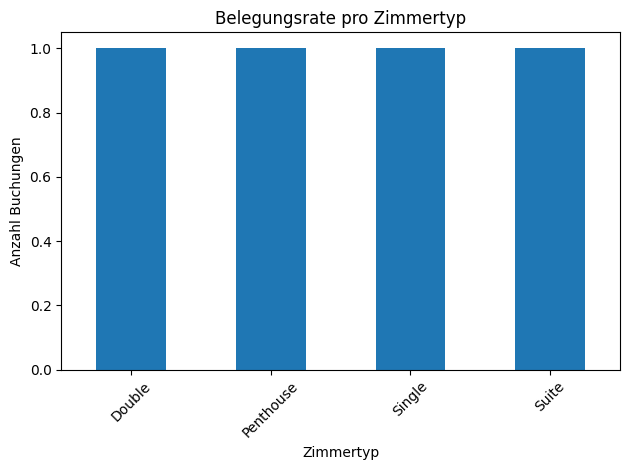